<a href="https://colab.research.google.com/github/JoanChege/CHATBOT1/blob/main/Chatbot_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. IMPORT EVERYTHING
2.   SET JSON FILE AS PANDAS DATAFRAME
3.   PREPROCESS THE DATA
4.   SPLIT DATA INTO TRAINING AND TESTING DATA





In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import re
import nltk
import json
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
#import the dataset
with open('/content/dataset3.json') as f:
    intents = json.load(f)




# Preprocess Data-remove stopwords
stop_words = set(stopwords.words('english'))

data = []
labels = []

#perform tokenization, filtering, lemmatizatiopn
if intents is not None:
  for intent in intents['intents']:
    for pattern in intent['patterns']:
        pattern = pattern.strip() # Remove leading/trailing whitespace
        tokenized_pattern = nltk.word_tokenize(pattern)
        filtered_pattern = [word.lower() for word in tokenized_pattern if word.isalnum() and not word in stop_words]
        lemmatizer = WordNetLemmatizer()
        lemmatized_pattern = lemmatized_pattern = [lemmatizer.lemmatize(word) for word in filtered_pattern]
        data.append(' '.join(lemmatized_pattern))
        labels.append(intent['tag'])
#The data list contains all the patterns, and the labels list contains all the corresponding intent tags.
# Create a Pandas DataFrame
df = pd.DataFrame({'Patterns': data, 'Tags': labels})

# Encode the Labels by converting tags into numerical form
encoder = LabelEncoder()
df['Tags'] = encoder.fit_transform(df['Tags'])
df['Tags'] = to_categorical(df['Tags'])

The encoding of the labels: The output of this code will be a DataFrame where the 'Tags' column has been converted into one-hot encoded binary values. This is useful for feeding the data into a neural network for text classification, where each class of text can be represented as a one-hot encoded vector.




In [ ]:
df

,Patterns,Tags
0,hi,0.0
1,hey,0.0
2,is anyone,0.0
3,hi,0.0
4,hello,0.0
...,...,...
5986,i think absolutely i need i think i realized t...,0.0
5987,what i supposed i ca get head i depressed some...,0.0
5988,med counseling sorted,0.0
5989,deleted,0.0


In [ ]:
import collections
word_counts = collections.Counter(data)
num_words = len(word_counts)

print(f"The number of unique words in the vocabulary is {num_words}")

The number of unique words in the vocabulary is 5789


PERFORM FEATURE EXTRACTION USING TDIF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#The CountVectorizer converts the text data into numerical vectors by counting the occurrence of each word in the text
vectorizer = CountVectorizer()
vectorizer.fit(data)

CountVectorizer()

In [ ]:
X = vectorizer.transform(data) # transform text to feature vectors

In [ ]:
y = df['Tags']

In [ ]:
train_ratio = 0.8 #80%
val_ratio = 0.1 #10%
test_ratio = 0.1 #10%

In [ ]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [ ]:
total = X.shape[0]

train_size = int(train_ratio * total)
val_size = int(val_ratio * total)
test_size = int(test_ratio * total)

In [ ]:
# Encode labels as unique intergers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
#y_train = np.array(labels)


In [ ]:
print(X.shape[0])
print(len(y))

5991
5991


In [ ]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split train into train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_train)

In [ ]:
print(X_train.shape[0])
print(len(y_train))

3833
3833


In [ ]:
print(X_test)

In [ ]:
print(y_train)

[1 1 1 ... 1 1 1]


In [ ]:
print(y_test)

[1 1 1 ... 1 1 1]


In [ ]:
num_classes = len(le.classes_)
y_train = np.reshape(y_train, (-1,1))

In [ ]:
model = Sequential()
model.add(Embedding(len(vectorizer.vocabulary_), 200, input_length=X_train.shape[1]))
#model.add(Bidirectional(LSTM(128, return_sequences=True)))
# Add 2 LSTM layers instead of 1
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(256, kernel_regularizer='l2'))
model.add(Dropout(0.8))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
print(y_train.shape)
print(model.predict(X_train).shape)

(3833, 1)
120/120 [==============================] - 50s 395ms/step
(3833, 318)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10412, 200)        2082400   
                                                                 
 lstm (LSTM)                 (None, 10412, 256)        467968    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 318)               2

In [ ]:
y_train = y_train.reshape(-1, 1)

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
y_train = np.resize(y_train, (num_classes,))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
num_classes = model.layers[-1].units

In [ ]:
y_train = np.resize(y_train, (X_train.shape[0],))

In [ ]:
print(X_train.shape)
print(y_train.shape)

(3833, 10412)
(3833,)


In [ ]:
hist = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose = 2)

Epoch 1/20
120/120 - 158s - loss: 3.1773 - accuracy: 0.7224 - val_loss: 1.2404 - val_accuracy: 0.8957 - 158s/epoch - 1s/step
Epoch 2/20
120/120 - 151s - loss: 1.2226 - accuracy: 0.9022 - val_loss: 1.2084 - val_accuracy: 0.8957 - 151s/epoch - 1s/step
Epoch 3/20
120/120 - 159s - loss: 1.0048 - accuracy: 0.9092 - val_loss: 1.4679 - val_accuracy: 0.8957 - 159s/epoch - 1s/step
Epoch 4/20
120/120 - 159s - loss: 0.9536 - accuracy: 0.9097 - val_loss: 1.3435 - val_accuracy: 0.8957 - 159s/epoch - 1s/step
Epoch 5/20
120/120 - 151s - loss: 0.8762 - accuracy: 0.9097 - val_loss: 1.5078 - val_accuracy: 0.8957 - 151s/epoch - 1s/step
Epoch 6/20
120/120 - 159s - loss: 0.8078 - accuracy: 0.9097 - val_loss: 1.5015 - val_accuracy: 0.8957 - 159s/epoch - 1s/step
Epoch 7/20
120/120 - 151s - loss: 0.8184 - accuracy: 0.9100 - val_loss: 1.5922 - val_accuracy: 0.8957 - 151s/epoch - 1s/step
Epoch 8/20
120/120 - 150s - loss: 0.7708 - accuracy: 0.9100 - val_loss: 1.7064 - val_accuracy: 0.8957 - 150s/epoch - 1s/step


In [43]:
import matplotlib.pyplot as plt
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

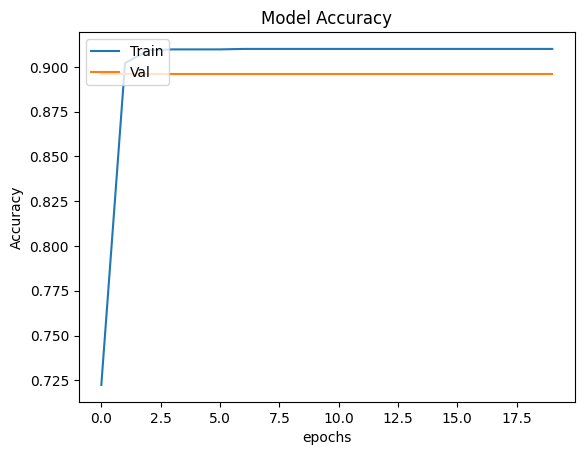

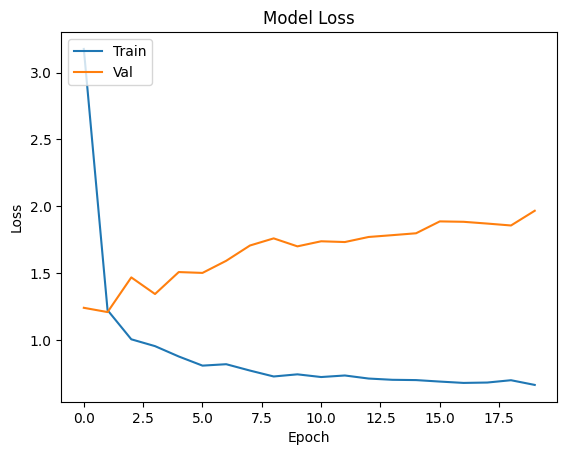

In [48]:
plot(hist)

EVALUATE THE MODEL

In [37]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import math

#convert the X_test and y_test into actual sentences
sentences = X_test.toarray()
references = y_test

# Take first sentence as example
reference = references[0]
candidate = sentences[0]

# Convert to strings
reference = [str(reference)]
candidate = str(candidate)

In [38]:
#calculate the BLEU score
cc = SmoothingFunction()
bleu = sentence_bleu(reference, candidate, smoothing_function = cc.method1)
print("BLEU score is: ", bleu)


#calculate the brevity penalty
def brevity_penalty(candidate, reference):
  c = len(candidate.split())
  r = len(reference[0].split())
  penalty = min(1, math.exp(1 - r/c))
  return penalty

bp = brevity_penalty(candidate, reference)
print("Brevity Penalty is: ", bp)

#adjust the bleu score with brevity penalty
bleu_bp = bleu * bp
print("BLEU score with Brevity Penalty is: ", bleu_bp)

BLEU score is:  0
Brevity Penalty is:  1
BLEU score with Brevity Penalty is:  0


In [39]:
model.save('chatbot_model.h5')
print('Done')

Done


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
